In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
from itertools import groupby
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2.2.2


In [13]:
df = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/lig47_hbonds_dict")

frames = [df[key]['distances'] for key in df.keys()]
combined = np.concatenate(frames, axis=1)
print(combined.shape)

dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/aro_contacts.npy")

dcharges = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/charge_dist_matrix.npy")
print(dcharges.shape)

hydrodf = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/hphob_dict_lig47")

frames = [hydrodf[key]['distance'] for key in hydrodf.keys()]
hydrocombined = np.concatenate(frames, axis=1)
print(hydrocombined.shape)

dmat = np.load("distance_matrix_full_LIG.npy")
print(dmat.shape)

def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]


(1100889, 314)
(1100889, 9)
(1100889, 1500)
(1100889, 20)


In [14]:
# inputs = torch.from_numpy(std_avg)
# inputs = torch.tensor(inputs, dtype=torch.float32)
# print(inputs.shape)
# print(inputs)
# targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
# targets = torch.tensor(targets, dtype=torch.float32)
# print(targets.shape)
# print(targets)
# dataset = TensorDataset(inputs, targets)

# N = dmat.shape[0]
N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

7895
[   0    1    2 ... 7892 7893 7894]
1128
[7895 7896 7897 ... 9020 9021 9022]
2256
[ 9023  9024  9025 ... 11276 11277 11278]


In [25]:
events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), len(combined[0,:])])
avg_aro_all = np.zeros([len(events_all), len(dfaro[0,:])])
avg_charges_all = np.zeros([len(events_all), len(dcharges[0,:])])
avg_hydro_all = np.zeros([len(events_all), len(hydrocombined[0,:])])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.mean(combined[event[0]:event[-1]+1], axis=0)
  avg_aro_all[count] = np.mean(dfaro[event[0]:event[-1]+1], axis=0)
  avg_charges_all[count] = np.mean(dcharges[event[0]:event[-1]+1], axis=0)
  avg_hydro_all[count] = np.mean(hydrocombined[event[0]:event[-1]+1], axis=0)
  count += 1
  
avg_new = np.concatenate([avg_all,avg_hbond_all, avg_aro_all, avg_hydro_all, avg_charges_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)


Longest five events: [12021  7432  5990  4327  3629]
Total events: 32264
With avg distance input data of shape: (32264, 1846)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 1846)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 1846)


In [26]:
mapping = mapping_5_476
avg = avg_5_476

print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=30
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))


max length: 476.0
min length: 5.0
max log length: 4.76
min log length: 0.05
mean: [1.42916224 1.37011894 1.31571755 ... 1.81294567 1.83956359 1.86437299]
std deviation: [0.48050119 0.49377814 0.52716466 ... 0.45693094 0.46340679 0.4674139 ]
standardized avg distance data
(7895, 1846)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.80187 | val_0_mse: 0.65531 |  0:00:04s
epoch 1  | loss: 0.69758 | val_0_mse: 0.51806 |  0:00:07s
epoch 2  | loss: 0.52745 | val_0_mse: 0.46252 |  0:00:11s
epoch 3  | loss: 0.49906 | val_0_mse: 0.46557 |  0:00:15s
epoch 4  | loss: 0.4715  | val_0_mse: 0.42528 |  0:00:19s
epoch 5  | loss: 0.42688 | val_0_mse: 0.45692 |  0:00:24s
epoch 6  | loss: 0.41237 | val_0_mse: 0.40329 |  0:00:28s
epoch 7  | loss: 0.39127 | val_0_mse: 0.35812 |  0:00:32s
epoch 8  | loss: 0.39114 | val_0_mse: 0.40556 |  0:00:37s
epoch 9  | loss: 0.4001  | val_0_mse: 0.36649 |  0:00:41s
epoch 10 | loss: 0.37716 | val_0_mse: 0.35789 |  0:00:45s
epoch 11 | loss: 0.37197 | val_0_mse: 0.3781  |  0:00:49s
epoch 12 | loss: 0.37634 | val_0_mse: 0.34179 |  0:00:54s
epoch 13 | loss: 0.38083 | val_0_mse: 0.34448 |  0:00:59s
epoch 14 | loss: 0.37284 | val_0_mse: 0.33453 |  0:01:03s
epoch 15 | loss: 0.37132 | val_0_mse: 0.34477 |  0:01:07s
epoch 16 | loss: 0.36652 | val_0_mse: 0.32785 |  0:01:12s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1.6901606  0.12868275 0.11384459 ... 0.13046467 0.2236551  2.1565857 ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
50.999794
52.27925531914894


In [27]:
top = (-al2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
top = (-ap2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
bottom = (ap2).argsort(axis=0)[:10]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted 153.09413 real: 475.0
predicted 78.29602 real: 471.0
predicted 165.16241 real: 467.0
predicted 217.24017 real: 467.0
predicted 195.17232 real: 461.00000000000006
predicted 201.21214 real: 461.00000000000006
predicted 168.54541 real: 454.0
predicted 134.34363 real: 454.0
predicted 279.80798 real: 448.00000000000006
predicted 168.49031 real: 443.0

predicted 333.733 real: 206.0
predicted 310.08594 real: 114.99999999999999
predicted 309.60117 real: 417.0
predicted 306.16656 real: 336.0
predicted 301.49423 real: 184.0
predicted 299.3279 real: 214.0
predicted 282.55566 real: 170.0
predicted 279.80798 real: 448.00000000000006
predicted 274.434 real: 313.0
predicted 271.1968 real: 390.0

predicted -3.9743562 real: 6.0
predicted -2.348288 real: 5.0
predicted -2.1391404 real: 8.0
predicted 0.79765713 real: 6.0
predicted 1.4185488 real: 6.0
predicted 1.591255 real: 6.0
predicted 2.4776275 real: 9.0
predicted 2.529396 real: 6.0
predicted 2.541017 real: 6.0
predicted 2.702345 real: 7.000

r2: 0.7253044310190869


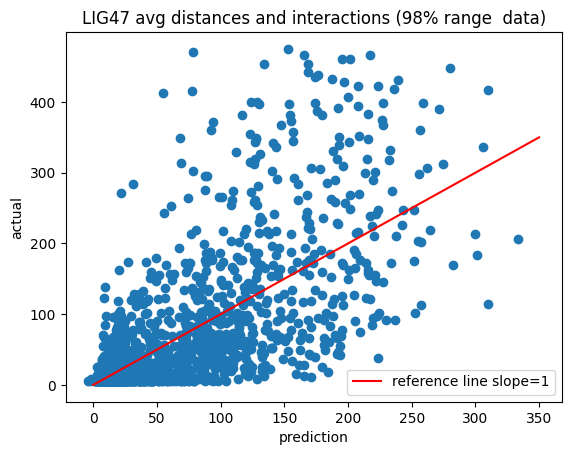

In [28]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 avg distances and interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()


r2: 0.7701109156030733


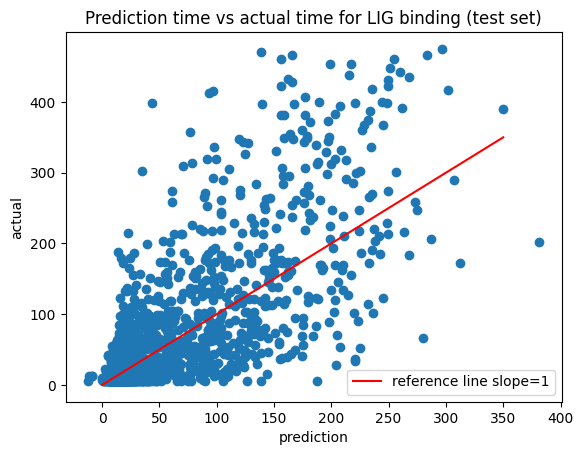

In [241]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#just distances averages

r2: 0.6919687910556457


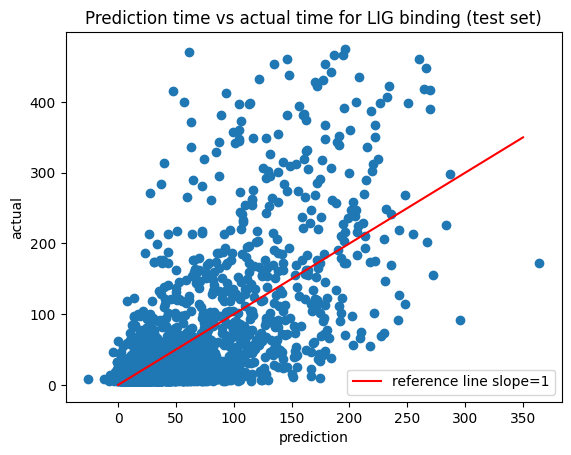

In [250]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#just h bonds averages

r2: 0.6592815556305677


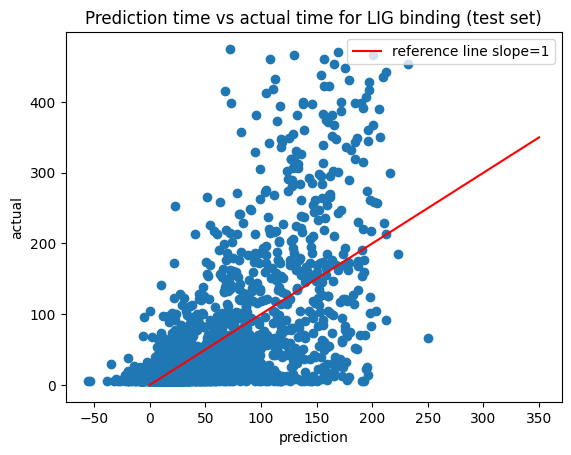

In [259]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#just charges averages

r2: 0.7263887013982742


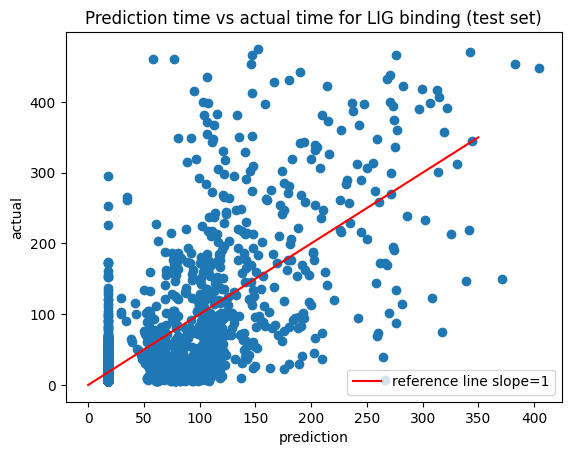

In [268]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#just aromatic averages

In [29]:
mapping = mapping_all
avg = avg_new

print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=80
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

max length: 12021.0
min length: 1.0
max log length: 120.21
min log length: 0.01
mean: [1.45652661 1.42421257 1.38172276 ... 1.90610295 1.9067522  1.91604801]
std deviation: [0.5443374  0.53097404 0.55025525 ... 0.52323857 0.54274858 0.55196261]
standardized avg distance data
(7895, 1846)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.40167 | val_0_mse: 0.97938 |  0:00:04s
epoch 1  | loss: 4.35161 | val_0_mse: 0.87562 |  0:00:08s
epoch 2  | loss: 4.19168 | val_0_mse: 0.84423 |  0:00:12s
epoch 3  | loss: 4.16819 | val_0_mse: 0.68097 |  0:00:16s
epoch 4  | loss: 3.91527 | val_0_mse: 0.78011 |  0:00:21s
epoch 5  | loss: 4.08967 | val_0_mse: 0.78582 |  0:00:25s
epoch 6  | loss: 3.97621 | val_0_mse: 0.784   |  0:00:29s
epoch 7  | loss: 3.83929 | val_0_mse: 0.95064 |  0:00:33s
epoch 8  | loss: 3.13734 | val_0_mse: 0.68747 |  0:00:37s
epoch 9  | loss: 3.84605 | val_0_mse: 0.70025 |  0:00:41s
epoch 10 | loss: 3.63094 | val_0_mse: 1.13946 |  0:00:45s
epoch 11 | loss: 1.88693 | val_0_mse: 0.75438 |  0:00:49s
epoch 12 | loss: 3.28326 | val_0_mse: 0.74457 |  0:00:53s
epoch 13 | loss: 3.70188 | val_0_mse: 0.79426 |  0:00:58s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_mse = 0.68097


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0.22116451 0.2593613  0.08588101 ... 0.01596491 0.06744133 0.21541595]
[0.01 0.34 0.01 ... 0.05 0.24 1.26]
25.21951
25.85328014184397


In [32]:
events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), len(combined[0,:])])
avg_aro_all = np.zeros([len(events_all), len(dfaro[0,:])])
avg_charges_all = np.zeros([len(events_all), len(dcharges[0,:])])
avg_hydro_all = np.zeros([len(events_all), len(hydrocombined[0,:])])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.mean(combined[event[0]:event[-1]+1], axis=0)
  avg_aro_all[count] = np.mean(dfaro[event[0]:event[-1]+1], axis=0)
  avg_charges_all[count] = np.mean(dcharges[event[0]:event[-1]+1], axis=0)
  avg_hydro_all[count] = np.mean(hydrocombined[event[0]:event[-1]+1], axis=0)
  count += 1
  
avg_new = np.concatenate([avg_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

Longest five events: [12021  7432  5990  4327  3629]
Total events: 32264
With avg distance input data of shape: (32264, 20)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 20)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 20)


In [33]:
mapping = mapping_5_476
avg = avg_5_476

print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=80
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

max length: 476.0
min length: 5.0
max log length: 4.76
min log length: 0.05
mean: [1.42916224 1.37011894 1.31571755 1.35058167 1.227108   1.24078511
 1.2223932  1.24681741 1.24418795 1.21032906 1.20343746 1.25658049
 1.1358778  1.14637195 1.17298661 1.11424589 1.15071183 1.22499229
 1.20205116 1.30301088]
std deviation: [0.48050119 0.49377814 0.52716466 0.51856525 0.50365845 0.50344977
 0.47637328 0.46924951 0.46724376 0.49043033 0.49153119 0.46918486
 0.45909269 0.45092947 0.47246284 0.47498547 0.50627984 0.51832394
 0.54566229 0.55149194]
standardized avg distance data
(7895, 20)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.10917 | val_0_mse: 0.63963 |  0:00:00s
epoch 1  | loss: 0.61592 | val_0_mse: 0.49514 |  0:00:00s
epoch 2  | loss: 0.50486 | val_0_mse: 0.49996 |  0:00:01s
epoch 3  | loss: 0.44788 | val_0_mse: 0.51212 |  0:00:01s
epoch 4  | loss: 0.42029 | val_0_mse: 0.48591 |  0:00:01s
epoch 5  | loss: 0.40238 | val_0_mse: 0.44915 |  0:00:02s
epoch 6  | loss: 0.38849 | val_0_mse: 0.44253 |  0:00:02s
epoch 7  | loss: 0.38428 | val_0_mse: 0.40708 |  0:00:02s
epoch 8  | loss: 0.37304 | val_0_mse: 0.38233 |  0:00:03s
epoch 9  | loss: 0.37471 | val_0_mse: 0.38245 |  0:00:03s
epoch 10 | loss: 0.36338 | val_0_mse: 0.3774  |  0:00:03s
epoch 11 | loss: 0.35667 | val_0_mse: 0.38215 |  0:00:04s
epoch 12 | loss: 0.35592 | val_0_mse: 0.39244 |  0:00:04s
epoch 13 | loss: 0.34702 | val_0_mse: 0.37599 |  0:00:04s
epoch 14 | loss: 0.33812 | val_0_mse: 0.37504 |  0:00:04s
epoch 15 | loss: 0.33695 | val_0_mse: 0.38392 |  0:00:05s
epoch 16 | loss: 0.343   | val_0_mse: 0.34662 |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1.6476364  0.17789653 0.15057991 ... 0.1237732  0.40711033 1.4679853 ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
46.332287
52.27925531914894


r2: 0.7701109156030733


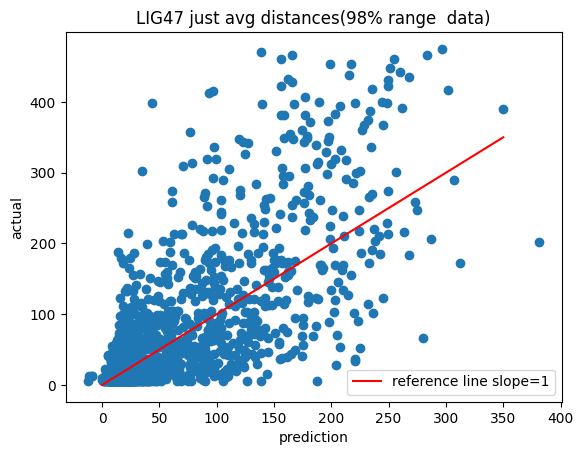

In [34]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 just avg distances(98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()